In [58]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
class SequenceDataset(Dataset):
    def __init__(self, df, exog_col='exog', endog_col='endog'):
        """
        df: a pandas DataFrame with two columns:
            - exog_col: list of integers (sequence)
            - endog_col: binary label (0 or 1)
        """
        self.sequences = df[exog_col].tolist()
        self.labels = df[endog_col].tolist()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [3]:
def collate_fn(batch):
    """
    Pads sequences in a batch to the same length.
    """
    # Separate sequences and labels
    sequences, labels = zip(*batch)

    # Find max length within this batch
    max_length = max(len(seq) for seq in sequences)

    # Pad sequences with 0 (or a special PAD token id if you have one)
    padded_sequences = []
    for seq in sequences:
        padded = seq + [34]*(max_length - len(seq))
        padded_sequences.append(padded)

    # Convert to tensors
    padded_sequences = torch.tensor(padded_sequences, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.float)

    return padded_sequences, labels

In [4]:
class TransformerBinaryClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim=64,
        num_heads=2,
        num_layers=2,
        ff_dim=128,
        dropout=0.1
    ):
        """
        vocab_size: size of the vocabulary (max integer token + 1).
        embed_dim: embedding dimension.
        num_heads: number of attention heads in the MultiheadAttention.
        num_layers: number of transformer encoder layers to stack.
        ff_dim: hidden dim in the feed-forward network of each encoder layer.
        dropout: dropout probability.
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Positional encoding (optional). If sequences can be very long,
        # consider a standard sinusoidal positional encoding approach.
        # Here we just show a simple learned positional embedding for demonstration:
        self.pos_embedding = nn.Embedding(5000, embed_dim)  # 5000 is arbitrary

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True  # ensures shape is (batch, seq, embed_dim)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.classifier = nn.Linear(embed_dim, 1)  # single output for binary

    def forward(self, x):
        """
        x: [batch_size, seq_len] of token IDs
        """
        batch_size, seq_len = x.shape

        # Token embeddings
        token_embeddings = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        # Positional embeddings (very simple version)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)  # [1, seq_len]
        pos_embeddings = self.pos_embedding(positions)  # [1, seq_len, embed_dim]

        # Combine token and positional embeddings
        embeddings = token_embeddings + pos_embeddings

        # Transformer Encoder
        encoder_output = self.transformer_encoder(embeddings)  
        # [batch_size, seq_len, embed_dim]

        # For classification, we often just take the output at the last token
        # or the pooled [CLS] representation if we have one. Another approach:
        # do a mean or max pooling across seq_len.
        # We'll do mean pooling across the sequence dimension:
        pooled_output = encoder_output.mean(dim=1)  # [batch_size, embed_dim]

        # Final linear layer -> raw logits
        logits = self.classifier(pooled_output).squeeze(-1)  # [batch_size]

        return logits

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3, device='cuda'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_acc = 0
        total_count = 0

        for sequences, labels in train_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            logits = model(sequences)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            preds = torch.sigmoid(logits)
            preds_class = (preds >= 0.5).float()
            acc = (preds_class == labels).float().sum()

            total_loss += loss.item() * sequences.size(0)
            total_acc += acc.item()
            total_count += sequences.size(0)

        avg_train_loss = total_loss / total_count
        avg_train_acc = total_acc / total_count

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

In [6]:
def evaluate_model(model, data_loader, device, criterion=None):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_count = 0

    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            logits = model(sequences)
            if criterion:
                loss = criterion(logits, labels)
                total_loss += loss.item() * sequences.size(0)

            preds = torch.sigmoid(logits)
            preds_class = (preds >= 0.5).float()
            acc = (preds_class == labels).float().sum()

            total_acc += acc.item()
            total_count += sequences.size(0)

    avg_loss = total_loss / total_count if criterion else 0
    avg_acc = total_acc / total_count

    return avg_loss, avg_acc

In [59]:
def evaluate_on_test_set(model, test_loader, device='cuda'):
    """
    Generates predictions on the test set, then plots the ROC curve and prints the AUC.
    """
    model.eval()
    
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(sequences)
            # Convert logits -> probabilities in [0, 1]
            probs = torch.sigmoid(logits)

            # Collect results for ROC
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Set ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Test AUC: {roc_auc:.3f}")

    return roc_auc

# Load and split

In [26]:
load = pd.read_csv('full_hands_df.csv')
load['seq'] = load['seq'].apply(ast.literal_eval)

In [27]:
load = load[['seq','is_chiitoi']]
load = load.rename(columns={'seq':'exog','is_chiitoi':'endog'})

In [48]:
load.shape

(210550, 2)

In [49]:
df = load.iloc[:10000].reset_index(drop=True)

In [50]:
train, test = train_test_split(df, test_size=0.2)

train, val = train_test_split(train, test_size=0.1)

In [51]:
val.shape

(800, 2)

# Train

In [52]:
train_dataset = SequenceDataset(train)
val_dataset = SequenceDataset(val)
test_dataset =  SequenceDataset(test)

In [53]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [54]:
vocab_size = 35

In [56]:
device = torch.device("cuda")

In [64]:
model = TransformerBinaryClassifier(
    vocab_size=vocab_size,
    embed_dim=32,
    num_heads=2,
    num_layers=2,
    ff_dim=64,
    dropout=0.1
)

In [57]:
train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3, device=device)

Epoch [1/5] Train Loss: 0.0847, Train Acc: 0.9840, Val Loss: 0.0963, Val Acc: 0.9800
Epoch [2/5] Train Loss: 0.0813, Train Acc: 0.9840, Val Loss: 0.0951, Val Acc: 0.9800
Epoch [3/5] Train Loss: 0.0805, Train Acc: 0.9840, Val Loss: 0.0990, Val Acc: 0.9800
Epoch [4/5] Train Loss: 0.0809, Train Acc: 0.9840, Val Loss: 0.0972, Val Acc: 0.9800
Epoch [5/5] Train Loss: 0.0814, Train Acc: 0.9840, Val Loss: 0.0979, Val Acc: 0.9800


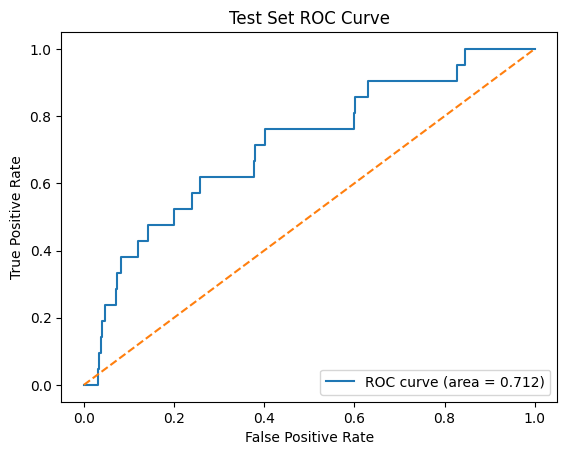

Test AUC: 0.712
Test AUC: 0.7124088645058831


In [60]:
model.to(device)
test_auc = evaluate_on_test_set(model, test_loader, device=device)
print("Test AUC:", test_auc)

In [65]:
model_1 = TransformerBinaryClassifier(
    vocab_size=vocab_size,
    embed_dim=32,
    num_heads=2,
    num_layers=1,
    ff_dim=64,
    dropout=0.1
)

In [66]:
train_model(model_1, train_loader, val_loader, num_epochs=5, lr=1e-3, device=device)

Epoch [1/5] Train Loss: 0.0860, Train Acc: 0.9829, Val Loss: 0.0940, Val Acc: 0.9800
Epoch [2/5] Train Loss: 0.0796, Train Acc: 0.9840, Val Loss: 0.1006, Val Acc: 0.9800
Epoch [3/5] Train Loss: 0.0772, Train Acc: 0.9840, Val Loss: 0.0939, Val Acc: 0.9800
Epoch [4/5] Train Loss: 0.0767, Train Acc: 0.9840, Val Loss: 0.0998, Val Acc: 0.9800
Epoch [5/5] Train Loss: 0.0760, Train Acc: 0.9840, Val Loss: 0.1021, Val Acc: 0.9800


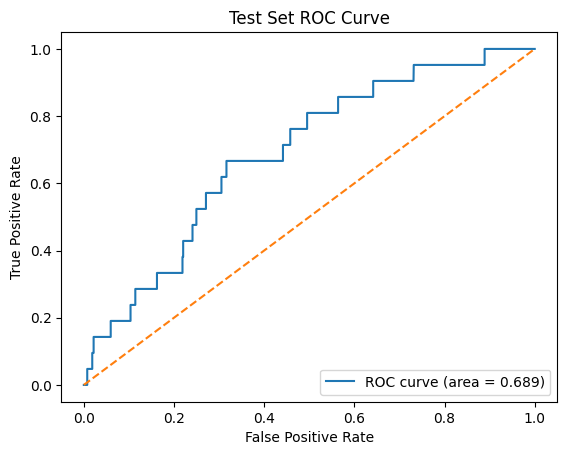

Test AUC: 0.689
Test AUC: 0.6890324598763204


In [67]:
model_1.to(device)
test_auc = evaluate_on_test_set(model_1, test_loader, device=device)
print("Test AUC:", test_auc)

In [68]:
model_1 = TransformerBinaryClassifier(
    vocab_size=vocab_size,
    embed_dim=32,
    num_heads=2,
    num_layers=3,
    ff_dim=64,
    dropout=0.1
)

In [69]:
train_model(model_1, train_loader, val_loader, num_epochs=5, lr=1e-3, device=device)

Epoch [1/5] Train Loss: 0.0835, Train Acc: 0.9839, Val Loss: 0.0986, Val Acc: 0.9800
Epoch [2/5] Train Loss: 0.0829, Train Acc: 0.9840, Val Loss: 0.0998, Val Acc: 0.9800
Epoch [3/5] Train Loss: 0.0825, Train Acc: 0.9840, Val Loss: 0.0981, Val Acc: 0.9800
Epoch [4/5] Train Loss: 0.0830, Train Acc: 0.9840, Val Loss: 0.0980, Val Acc: 0.9800
Epoch [5/5] Train Loss: 0.0829, Train Acc: 0.9840, Val Loss: 0.0992, Val Acc: 0.9800


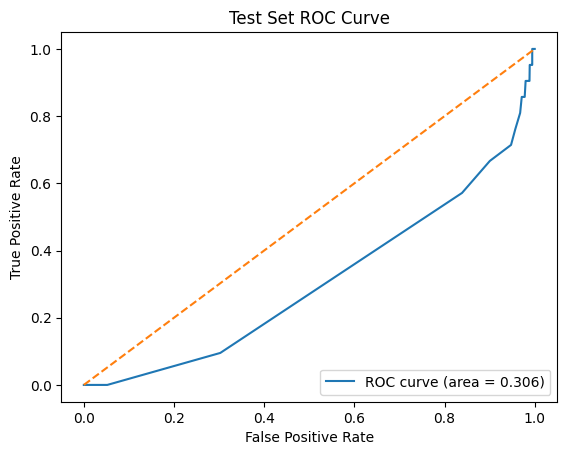

Test AUC: 0.306
Test AUC: 0.30613104261411483


In [70]:
model_1.to(device)
test_auc = evaluate_on_test_set(model_1, test_loader, device=device)
print("Test AUC:", test_auc)

# Explainability